<a href="https://colab.research.google.com/github/lotrmay/TensorFlow_Learning/blob/master/bc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [213]:
%tensorflow_version 2.x
import tensorflow as tf
import pickle
import keras
import numpy as np #better arrays in python, lepší práce s multidimenzionálními poli
import pandas as pd #data analytics tool, lepší manipulace s daty, dokáže například cut outnout column
import matplotlib.pyplot as plt #vizualizace tabulek a grafů
import sklearn
from google.colab import drive


#CSV_COLUMN_NAMES označuje nadpisy sloupců v csv soubour
CSV_COLUMN_NAMES=['Odds_firstTeam','Odds_secondTeam','Rank_firstTeam','Rank_secondTeam','WinRate_firstTeam','WinRate_secondTeam','PistolWinRate_firstTeam','PistolWinRate_secondTeam',
                  'playerAARating','playerAADpr','playerAAKast','playerAAImpact','playerAAAdr','playerAAKpr','playerAAHs','playerAAKD','playerAAGrenadeDmg',
                  'playerABRating','playerABDpr','playerABKast','playerABImpact','playerABAdr','playerABKpr','playerABHs','playerABKD','playerABGrenadeDmg',
                  'playerACRating','playerACDpr','playerACKast','playerACImpact','playerACAdr','playerACKpr','playerACHs','playerACKD','playerACGrenadeDmg',
                  'playerADRating','playerADDpr','playerADKast','playerADImpact','playerADAdr','playerADKpr','playerADHs','playerADKD','playerADGrenadeDmg',
                  'playerAERating','playerAEDpr','playerAEKast','playerAEImpact','playerAEAdr','playerAEKpr','playerAEHs','playerAEKD','playerAEGrenadeDmg',
                  'playerBARating','playerBADpr','playerBAKast','playerBAImpact','playerBAAdr','playerBAKpr','playerBAHs','playerBAKD','playerBAGrenadeDmg',
                  'playerBBRating','playerBBDpr','playerBBKast','playerBBImpact','playerBBAdr','playerBBKpr','playerBBHs','playerBBKD','playerBBGrenadeDmg',
                  'playerBCRating','playerBCDpr','playerBCKast','playerBCImpact','playerBCAdr','playerBCKpr','playerBCHs','playerBCKD','playerBCGrenadeDmg',
                  'playerBDRating','playerBDDpr','playerBDKast','playerBDImpact','playerBDAdr','playerBDKpr','playerBDHs','playerBDKD','playerBDGrenadeDmg',
                  'playerBERating','playerBEDpr','playerBEKast','playerBEImpact','playerBEAdr','playerBEKpr','playerBEHs','playerBEKD','playerBEGrenadeDmg','Match_link','Result','team_one_name','team_two_name']

dataset=pd.read_csv('/content/data.csv',sep=";",names=CSV_COLUMN_NAMES,error_bad_lines=False,header=None)#vytvoří dataframe z našeho csv souboru
print(dataset.shape)#vypíše nám dimenzionalitu našeho dataframu např.(2, 3) 2 řádky 3 sloupce

#následující 2 řádky nám upraví dva sloupce z textových na číselné formáty (category datatype)
dataset['team_one_name']=pd.Categorical(dataset['team_one_name']).codes #sníží využití paměti z 1.2MB na 0.03 MB viz: https://towardsdatascience.com/staying-sane-while-adopting-pandas-categorical-datatypes-78dbd19dcd8a
dataset['team_two_name']=pd.Categorical(dataset['team_two_name']).codes

#Odstraním z dataframu následující sloupce (odkaz na zápas a jména týmů), jelikož jsem je využíval pouze při sběru dat
dataset.pop('Match_link')
dataset.pop('team_one_name')
dataset.pop('team_two_name')
#https://stackoverflow.com/questions/29576430/shuffle-dataframe-rows
#frac=1 znamená, vrať všechny řádky
dataset = dataset.sample(frac=1).reset_index(drop=True) #náhodně zamícháme řádky (můžeme využít seed)

main_scaler=sklearn.preprocessing.StandardScaler()#standardscaler narozdíl od minmaxscaleru vykazuje o 2 procenta lepší přesnost, navíc je logické ho použít
y = dataset['Result'].values
dataset.pop('Result')
X = dataset.values


(18930, 102)


In [214]:
#určíme outliers (odlehlé hodnoty, které by mohly být při tréninku pro model škodlivé)
#zkráceně řečeno zjistíme odlehlou hodnotu tak, že ve svém okolí má oproti jiným hodnotám o dost méně "sousedů"
#5% dat 
#https://machinelearningmastery.com/model-based-outlier-detection-and-removal-in-python/
#https://datascience.stackexchange.com/questions/75702/when-should-you-remove-outliers
from sklearn.ensemble import IsolationForest #0.412 mae
from sklearn.svm import OneClassSVM #0.412 mae
from sklearn.covariance import EllipticEnvelope #0.412 mae
#lof Minimum Covariance Determinant One-Class SVM
iso = LocalOutlierFactor(contamination=0.05)
yhat = iso.fit_predict(X)
# select all rows that are not outliers
mask = yhat != -1
X, y = X[mask, :], y[mask]
# summarize the shape of the updated training dataset
print(X.shape, y.shape)
yhat = model.predict(X_test)
# evaluate predictions
#mae = sklearn.metrics.mean_absolute_error(y_test, yhat)
#print('MAE: %.3f' % mae)

(17983, 98) (17983,)


In [215]:
#rozdělíme náš dataframe na trénovací, testovací a validační dataset
#testovací dataset bude 15% 
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, test_size=0.15)#32 #888 887

#validační set bude 15% 
X_train, X_val, y_train, y_val = sklearn.model_selection.train_test_split(X_train, y_train, test_size=0.1764) # 0.1764 x 0.859 = 0.15 

print(X_train.shape) 
print(X_test.shape)
print(X_val.shape) 

#scalujeme data aby si model nemyslel, že větší číselný řád indikuje větší důležitost atributu
#https://stackoverflow.com/questions/51237635/difference-between-standard-scaler-and-minmaxscaler
#https://datascience.stackexchange.com/questions/43972/when-should-i-use-standardscaler-and-when-minmaxscaler

#nepoužíváme minmaxscaler, protože naše data by měly být "normálně" distribuovány


main_scaler.fit(X_train)#model pracuje jen s poznatky, které získal na trénovacím datasetu, proto později používám pouze transform na trénovacím datasetu

X_train=main_scaler.transform(X_train)#:https://stackoverflow.com/questions/49444262/normalize-data-before-or-after-split-of-training-and-testing-data
X_test=main_scaler.transform(X_test)
X_val=main_scaler.transform(X_val)

(12588, 98)
(2698, 98)
(2697, 98)


Epoch 1/200
99/99 [==============================] - 2s 7ms/step - loss: 0.6703 - binary_accuracy: 0.6004 - val_loss: 0.6394 - val_binary_accuracy: 0.6244

Epoch 00001: val_loss improved from inf to 0.63939, saving model to current_model.h5
Epoch 2/200
99/99 [==============================] - 1s 5ms/step - loss: 0.6414 - binary_accuracy: 0.6378 - val_loss: 0.6187 - val_binary_accuracy: 0.6637

Epoch 00002: val_loss improved from 0.63939 to 0.61870, saving model to current_model.h5
Epoch 3/200
99/99 [==============================] - 1s 5ms/step - loss: 0.6340 - binary_accuracy: 0.6438 - val_loss: 0.6264 - val_binary_accuracy: 0.6770

Epoch 00003: val_loss did not improve from 0.61870
Epoch 4/200
99/99 [==============================] - 1s 5ms/step - loss: 0.6374 - binary_accuracy: 0.6420 - val_loss: 0.6211 - val_binary_accuracy: 0.6607

Epoch 00004: val_loss did not improve from 0.61870
Epoch 5/200
99/99 [==============================] - 1s 5ms/step - loss: 0.6355 - binary_accuracy: 0

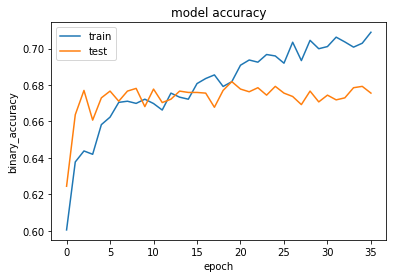

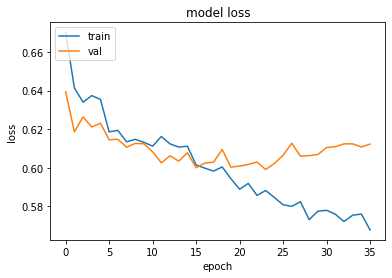

In [346]:
#data máme připravena, tak vytvoříme sequential model, jelikož potřebujeme mít více vrstev, ale máme pouze 1 input (zápas) a output 0;1
model = keras.models.Sequential()
model.add(keras.layers.InputLayer(input_shape=(98)))#https://towardsdatascience.com/17-rules-of-thumb-for-building-a-neural-network-93356f9930af
model.add(keras.layers.Dropout(rate=0.2)) 
model.add(keras.layers.Dense(512,activation='relu'))
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.Dense(256,activation='relu'))
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.Dense(128,activation='relu'))
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.Dense(64,activation='relu'))
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.Dense(32,activation='relu'))
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.Dense(16,activation='relu'))
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.Dense(1, activation='sigmoid'))

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), 
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=False), #https://machinelearningmastery.com/how-to-choose-loss-functions-when-training-deep-learning-neural-networks/
              metrics=['binary_accuracy'])

reduce_lr_callback = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=0.001,verbose=1)
checkpoint_callback=tf.keras.callbacks.ModelCheckpoint('current_model.h5', monitor='val_loss', verbose=1, save_best_only=True)
early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=12,verbose=1)#patience-kolik epoch se nezmění val_loss pak stop

history = model.fit(X_train, y_train, epochs=200, shuffle=True,batch_size=128,validation_data=(X_val, y_val), 
                    callbacks=[reduce_lr_callback,checkpoint_callback,early_stopping_callback])#steps
train_predictions= model.predict(X_train)
train_accuracy_score = model.evaluate(X_train, y_train, verbose=0)
print('Accuracy on training data: {:.2%} \n Error on training data: {:.2%}'.format(train_accuracy_score[1],  1 - train_accuracy_score[1]))#úspěšnost na trénovacím setu   


test_predictions= model.predict(X_test)
test_accuracy_score= model.evaluate(X_test, y_test, verbose=0)# zkusit změnit verbose zde a nahoře na 1 a 2 mělo by to zobrazovat více údajů při tréninku
print('Accuracy on test data: {:.2%} \n Error on test data: {:.2%}'.format(test_accuracy_score[1], 1 - test_accuracy_score[1]))#úspěšnost na testovacím setu

plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])

plt.title('model accuracy')
plt.ylabel('binary_accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()



In [348]:
#model.save('/content/save/model707.h5')
model= keras.models.load_model("current_model.h5")

scaledData=main_scaler.transform(X)
pred_test= model.predict(scaledData)
scores2 = model.evaluate(scaledData, y, verbose=1)# zkusit změnit verbose zde a nahoře na 1 a 2 mělo by to zobrazovat více údajů při tréninku
print('Accuracy on the whole dataset: {:.2%} \n Error on the whole dataset: {:.2%}'.format(scores2[1], 1 - scores2[1]))#úspěšnost na testovacím setu


#pickle.dump(main_scaler, open("/content/save/scaler707.pkl", 'wb'))#save the scaler 

562/562 [==============================] - 2s 3ms/step - loss: 0.5734 - binary_accuracy: 0.7069
Accuracy on the whole dataset: 70.69% 
 Error on the whole dataset: 29.31%


In [349]:
main_scaler = pickle.load(open("scaler707.pkl", 'rb'))
Xnew=np.array([[1.58,2.31,62,164,0.44,0.38,0.5,0.5,0.95,0.73,0.66,0.99,70.9,0.65,0.55,0.89,4.4,1.03,0.68,0.69,0.89,78.2,0.69,0.54,1.01,4.0,1.08,0.64,0.69,1.12,72.1,0.71,0.23,1.10,3.8,0.87,0.7,0.67,0.74,64.0,0.58,0.6,0.82,3.8,0.97,0.75,0.67,1.06,74.7,0.65,0.59,0.86,5.0,1.07,0.71,0.67,1.25,76.9,0.73,0.56,1.02,3.1,1.04,0.71,0.69,1.08,77.1,0.69,0.48,0.97,6.0,0.99,0.67,0.67,0.91,69.4,0.67,0.29,0.99,3.5,0.9,0.72,0.66,0.84,70.8,0.55,0.45,0.76,9.5,0.87,0.67,0.65,0.74,65.9,0.56,0.53,0.84,4.2],
               [2.35,1.55,98,111,0.67,0.61,0.5,0.5,1.18,0.64,0.76,1.08,83.3,0.79,0.5,1.23,5.0,1.16,0.57,0.75,1.06,74.0,0.74,0.56,1.30,5.0,1.13,0.69,0.72,1.19,82.4,0.69,0.44,1.00,9.1,1.12,0.63,0.72,1.09,74.8,0.72,0.25,1.14,6.6,1.1,0.66,0.71,1.16,78.2,0.68,0.46,1.03,8.2,1.23,0.56,0.72,1.24,77.6,0.82,0.39,1.45,1.9,1.17,0.64,0.74,1.12,82.4,0.74,0.52,1.16,4.1,1.1,0.65,0.72,1.07,76.0,0.71,0.55,1.09,4.6,1.07,0.66,0.72,1.04,75.0,0.68,0.4,1.02,4.5,1.05,0.64,0.74,0.88,72.9,0.64,0.53,1.00,5.0],
               [2.34,1.57,37,39,0.54,0.83,0.555,0.5,1.18,0.67,0.72,1.22,86.3,0.75,0.49,1.11,7.1,1.08,0.67,0.75,1.0,75.3,0.67,0.42,1.00,3.1,1.06,0.6,0.71,1.0,66.6,0.69,0.29,1.14,3.5,1.06,0.67,0.7,1.03,74.7,0.69,0.58,1.02,3.8,0.95,0.69,0.71,0.82,69.2,0.6,0.46,0.87,3.2,1.37,0.59,0.76,1.46,88.9,0.88,0.34,1.51,4.7,1.19,0.65,0.71,1.24,86.2,0.76,0.48,1.16,7.4,1.03,0.66,0.69,1.0,72.9,0.66,0.66,1.00,5.2,1.1966666666666665,0.6333333333333333,0.7200000000000001,1.2333333333333334,82.66666666666667,0.7666666666666667,0.49333333333333335,1.2233333333333334,5.766666666666667,1.1966666666666665,0.6333333333333333,0.7200000000000001,1.2333333333333334,82.66666666666667,0.7666666666666667,0.49333333333333335,1.2233333333333334,5.766666666666667],
               [1.67,2.14,36,92,0.77,0.48,0.5,0.5,1.3,0.58,0.8,1.13,87.4,0.82,0.52,1.42,3.3,1.23,0.57,0.75,1.23,78.0,0.77,0.27,1.36,3.0,1.18,0.64,0.75,1.24,81.4,0.74,0.5,1.14,6.2,1.05,0.67,0.7,1.08,73.3,0.69,0.52,1.02,5.8,1.05,0.61,0.74,0.91,72.1,0.63,0.45,1.03,3.6,1.12,0.64,0.7,1.2,75.3,0.71,0.34,1.12,4.2,1.08,0.66,0.72,1.04,76.0,0.7,0.54,1.06,7.2,1.01,0.68,0.69,0.97,73.4,0.64,0.44,0.94,5.1,0.95,0.67,0.68,0.87,72.2,0.58,0.45,0.87,10.8,0.97,0.65,0.71,0.81,68.2,0.61,0.52,0.93,4.8],
               [1.91,1.85,165,178,0.47,0.57,0.5,0.5,1.3,0.68,0.77,1.34,89.3,0.86,0.61,1.26,5.3,1.08,0.67,0.72,1.07,74.7,0.68,0.41,1.01,5.9,1.01,0.68,0.7,1.0,70.6,0.65,0.57,0.96,2.9,0.98,0.72,0.68,0.94,72.8,0.64,0.43,0.90,2.9,0.96,0.66,0.69,0.89,63.9,0.6,0.46,0.92,2.0,1.17,0.71,0.73,1.24,86.9,0.76,0.63,1.07,5.0,1.11,0.66,0.73,1.01,77.2,0.78,0.52,1.18,2.3,1.03,0.7,0.69,1.04,76.1,0.66,0.56,0.95,3.0,0.97,0.66,0.71,0.95,63.1,0.57,0.37,0.88,1.5,0.92,0.71,0.67,0.94,65.3,0.58,0.52,0.82,3.1],
               [1.43,2.75,52,89,0.45,0.52,0.526,0.5,1.13,0.66,0.73,1.11,79.0,0.74,0.55,1.12,4.9,1.1,0.65,0.72,1.14,75.0,0.69,0.37,1.06,6.1,1.01,0.68,0.7,1.01,70.6,0.65,0.53,0.96,3.4,0.95,0.68,0.67,0.91,70.7,0.6,0.51,0.88,6.2,1.0475,0.6675000000000001,0.705,1.0425,73.825,0.67,0.49000000000000005,1.0050000000000001,5.15,1.33,0.66,0.76,1.44,94.2,0.85,0.58,1.30,8.3,1.13,0.61,0.73,1.02,78.3,0.73,0.58,1.20,4.1,1.11,0.6,0.7,1.15,73.3,0.68,0.28,1.13,4.1,1.06,0.72,0.7,1.18,75.4,0.68,0.51,0.93,5.4,0.97,0.58,0.72,0.8,62.4,0.57,0.62,0.98,4.7],
               [2.2,1.6,33,42,0.51,0.5,0.447,0.522,1.19,0.63,0.74,1.14,83.4,0.78,0.53,1.24,4.8,1.12,0.61,0.7,1.13,75.1,0.71,0.33,1.16,4.3,1.08,0.73,0.69,1.18,80.2,0.69,0.59,0.95,6.2,1.01,0.64,0.73,0.83,68.7,0.64,0.45,1.01,3.6,0.84,0.71,0.65,0.77,60.3,0.54,0.44,0.77,3.9,1.15,0.7,0.71,1.24,85.4,0.75,0.52,1.08,4.3,1.09,0.64,0.7,1.04,75.6,0.73,0.36,1.14,3.4,1.02,0.64,0.7,0.92,71.6,0.63,0.53,0.98,5.1,0.99,0.67,0.68,0.94,69.5,0.65,0.55,0.97,3.1,0.98,0.67,0.69,0.92,69.6,0.61,0.5,0.92,4.6],
               [1.98,1.77,25,21,0.71,0.63,0.522,0.532,1.18,0.66,0.72,1.22,85.6,0.77,0.6,1.16,5.2,1.16,0.59,0.74,1.11,75.0,0.73,0.32,1.24,3.1,1.12,0.62,0.73,1.07,74.4,0.71,0.58,1.14,3.0,1.1,0.65,0.72,1.07,77.4,0.71,0.54,1.10,3.7,0.93,0.67,0.69,0.88,64.5,0.57,0.51,0.85,5.8,1.14,0.59,0.72,1.17,72.5,0.72,0.28,1.22,2.2,1.1,0.61,0.72,1.01,76.1,0.67,0.43,1.10,4.7,1.1,0.68,0.71,1.11,79.3,0.72,0.54,1.06,4.3,1.01,0.69,0.7,0.98,73.4,0.63,0.53,0.92,7.1,1.0875000000000001,0.6425,0.7124999999999999,1.0675,75.32499999999999,0.685,0.445,1.0750000000000002,4.574999999999999],
               [1.5,2.44,65,81,0.71,0.43,0.587,0.5,1.39,0.5,0.79,1.36,83.9,0.86,0.33,1.74,2.9,1.14,0.59,0.72,1.15,75.9,0.7,0.49,1.19,4.4,1.14,0.62,0.73,1.12,79.5,0.69,0.52,1.10,4.6,1.12,0.62,0.72,1.06,77.4,0.72,0.55,1.15,4.1,1.02,0.62,0.72,0.86,68.8,0.6,0.62,0.97,4.5,1.13,0.62,0.72,1.1,76.2,0.73,0.26,1.17,2.7,1.03,0.68,0.69,1.01,73.2,0.68,0.6,1.00,5.2,1.01,0.71,0.67,1.1,72.4,0.67,0.73,0.94,3.2,0.97,0.66,0.67,0.91,70.5,0.62,0.43,0.93,4.1,1.035,0.6675,0.6875,1.03,73.075,0.675,0.505,1.01,3.8000000000000003],
               [2.44,1.5,63,68,0.58,0.85,0.571,0.5,1.26,0.65,0.73,1.35,89.8,0.82,0.5,1.26,3.2,1.13,0.69,0.72,1.19,80.9,0.76,0.53,1.09,3.6,1.13,0.67,0.72,1.16,78.9,0.75,0.41,1.12,2.7,0.96,0.64,0.7,0.83,64.9,0.6,0.39,0.94,3.9,1.1199999999999999,0.6625,0.7175,1.1325,78.625,0.7325,0.4575,1.1025,3.35,1.17,0.61,0.72,1.16,77.8,0.76,0.23,1.25,3.1,1.15,0.63,0.75,1.09,79.9,0.7,0.55,1.12,5.8,1.12,0.7,0.7,1.3,79.7,0.72,0.4,1.02,4.3,1.11,0.61,0.74,0.97,73.5,0.69,0.55,1.14,4.4,1.11,0.64,0.74,1.05,75.1,0.71,0.54,1.10,4.0],
               [2.15,1.65,108,69,0.42,0.43,0.5,0.542,1.11,0.63,0.71,1.06,77.1,0.72,0.35,1.13,6.6,0.93,0.69,0.68,0.87,68.3,0.6,0.48,0.86,8.8,0.98,0.71,0.66,1.03,72.8,0.67,0.47,0.94,3.4,0.89,0.69,0.68,0.8,64.7,0.58,0.55,0.84,4.4,0.83,0.73,0.63,0.79,66.6,0.54,0.4,0.75,7.9,1.05,0.69,0.73,0.98,75.9,0.66,0.63,0.96,5.2,1.02,0.71,0.69,1.1,71.1,0.68,0.27,0.96,4.1,0.96,0.73,0.69,0.93,73.0,0.65,0.42,0.89,5.0,0.96,0.69,0.64,0.93,73.5,0.63,0.5,0.92,6.4,0.95,0.63,0.68,0.9,64.0,0.6,0.37,0.94,3.2]
               ])
Xnew = pd.DataFrame(Xnew, columns=CSV_CL_NAMES_WITHOUT_RESULTS)
pokus=main_scaler.transform(Xnew)
model= keras.models.load_model("model707.h5")
ynew=(model.predict([pokus]))
print(ynew)

[[0.29223916]
 [0.5625956 ]
 [0.44249773]
 [0.35486004]
 [0.31789196]
 [0.34096873]
 [0.4005051 ]
 [0.579666  ]
 [0.37754938]
 [0.73948824]
 [0.6405622 ]]


In [121]:
n = 2 # Max number of neighbours you want to consider
param_grid = {'n_neighbors': np.arange(n)}
grid = sklearn.model_selection.GridSearchCV(sklearn.neighbors.KNeighborsClassifier(), param_grid)
grid.fit(X,y)
print(grid.best_params_)
#pro 300 nabízí 153

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Expected n_neighbors > 0. Got 0

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Expected n_neighbors > 0. Got 0

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Expected n_neighbors > 0. Got 0

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for 

{'n_neighbors': 1}


In [112]:
pd.set_option("display.max_rows", 999)
pd.set_option("display.max_columns", 999)
pd.set_option("expand_frame_repr", True)
pd.set_option("large_repr", "info")
drive.mount('/content/drive')




poznatky-vypadá to, že grenade damage každého hráče je nadbytečná a síť bez této informace vykazuje lepší výsledky!!

optimální batch_size je 128 zjištěno zkoušením

kernel inity
he_uniform>he_normal
lecun uniform>lecun normal 
orthogonal a variance scaling použitelné

bias inity
lecun normal >he normal, variance_scaling
https://www.tensorflow.org/api_docs/python/tf/keras/initializers
val loss u callbacků nebo val_accuracy?
model.add(Dense(512, kernel_initializer=tf.initializers.lecun_uniform,bias_initializer=tf.initializers.lecun_normal))

nejlepší model měl zatím 512,256,128 i když to není doporučováno